In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

Hypothesis Testing
As part of your analysis, you'll conduct hypothesis testing to make data-driven conclusions about the effectiveness of the redesign. See the full details below:

1) COMPLETION RATE
2) COMPLETION RATE WITH A COST-EFFECTIVENESS THRESHOLD
3) OTHER HYPOTHESIS EXAMPLES

In [18]:
# Load your CSV or paste raw data
df = pd.read_csv("/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_merged_web_data_pt.txt", parse_dates=["date_time"])
variation_df = pd.read_csv("/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_experiment_clients_data.txt")
demographics_df = pd.read_csv("/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_final_demo_cleaned.txt")

1) COMPLETION RATE

In [5]:
# Step 0: Merge variation info into df by client_id
df = df.merge(variation_df, on="client_id", how="left")

# Sort actions chronologically per visit
df = df.sort_values(by=["visit_id", "date_time"])

# Remove duplicate steps per visit (to avoid loops/skips being counted multiple times)
df_unique_steps = df.drop_duplicates(subset=["visit_id", "process_step"])

# Define the correct step order for the funnel
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Calculate funnel conversions per Variation group
funnel_per_variation = (
    df_unique_steps.groupby(["Variation", "process_step"])["visit_id"]
    .nunique()
    .reindex(step_order, level=1, fill_value=0)  # reindex steps per variation
    .reset_index()
)

# Calculate funnel metrics per group
def compute_funnel_metrics(df_group):
    df_group = df_group.set_index("process_step").reindex(step_order, fill_value=0)
    df_group = df_group.rename(columns={"visit_id": "num_visits"})
    df_group["conversion_rate"] = df_group["num_visits"] / df_group["num_visits"].iloc[0] * 100  # from start
    df_group["step_conversion"] = df_group["num_visits"] / df_group["num_visits"].shift(1) * 100
    return df_group

# Apply for each variation
result = funnel_per_variation.groupby("Variation").apply(compute_funnel_metrics)

# Display results
for variation in result.index.levels[0]:
    print(f"\nFunnel Conversion for Variation: {variation}\n")
    print(result.loc[variation])


Funnel Conversion for Variation: Control

             Variation  num_visits  conversion_rate  step_conversion
process_step                                                        
start          Control       30741       100.000000              NaN
step_1         Control       23394        76.100322        76.100322
step_2         Control       19997        65.049933        85.479183
step_3         Control       18165        59.090466        90.838626
confirm        Control       15912        51.761491        87.597027

Funnel Conversion for Variation: Test

             Variation  num_visits  conversion_rate  step_conversion
process_step                                                        
start             Test       33017       100.000000              NaN
step_1            Test       28148        85.253051        85.253051
step_2            Test       24378        73.834691        86.606508
step_3            Test       22069        66.841324        90.528345
confirm           Te

/var/folders/_2/ksgd3nl52j9g0sxwpjjd1bgh0000gn/T/ipykernel_11211/4200738623.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = funnel_per_variation.groupby("Variation").apply(compute_funnel_metrics)


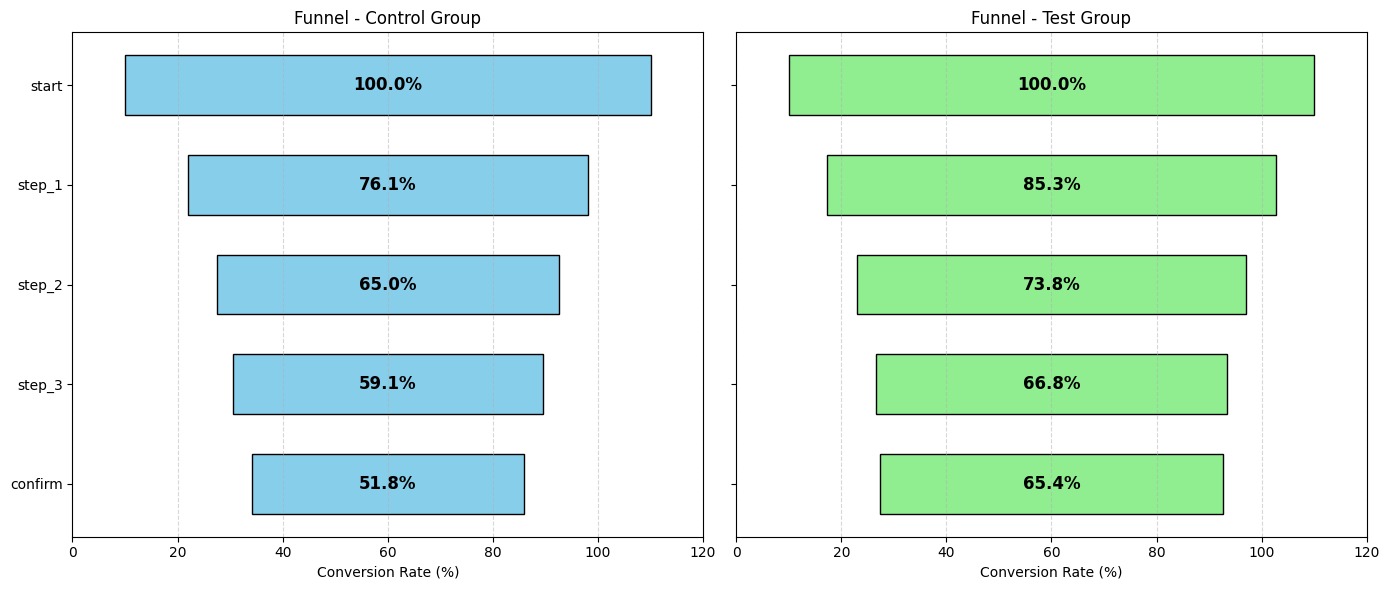

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
x_center = 60  # center for bars

def plot_centered_bars_with_step_conversion(ax, data, title, color):
    data = data.reindex(step_order)
    data = data[::-1]  # invert order so start is at top

    steps = data.index.tolist()
    conversion_rate = data["conversion_rate"].tolist()
    step_conversion = data["step_conversion"].tolist()
    step_conversion_inv = step_conversion[::-1]

    y = np.arange(len(steps))
    left_offsets = [x_center - (val / 2) for val in conversion_rate]

    for i in range(len(steps)):
        ax.barh(y[i], conversion_rate[i], height=0.6, left=left_offsets[i],
                color=color, edgecolor='black')
        ax.text(x_center, y[i], f"{conversion_rate[i]:.1f}%", ha='center', va='center',
                fontsize=12, fontweight='bold', color='black')

    ax.set_yticks(y)
    ax.set_yticklabels(steps)
    ax.set_xlim(0, 120)
    ax.set_xlabel("Conversion Rate (%)")
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

# Control plot
plot_centered_bars_with_step_conversion(axes[0], result.loc['Control'], "Funnel - Control Group", 'skyblue')

# Test plot
plot_centered_bars_with_step_conversion(axes[1], result.loc['Test'], "Funnel - Test Group", 'lightgreen')

plt.tight_layout()
plt.show()

In [7]:
pivot = funnel_per_variation.pivot(index='process_step', columns='Variation', values='visit_id').fillna(0)

# Total visits per group (at start step)
total_control = pivot.loc['start', 'Control']
total_test = pivot.loc['start', 'Test']

print(f"Total Control visits: {total_control}")
print(f"Total Test visits: {total_test}\n")

print("Step-wise significance test (two-proportion z-test):\n")

for step in step_order:
    control_success = pivot.loc[step, 'Control']
    test_success = pivot.loc[step, 'Test']

    successes = np.array([test_success, control_success])
    trials = np.array([total_test, total_control])

    stat, pval = proportions_ztest(successes, trials)
    print(f"{step:8} | Test: {test_success}/{total_test} | Control: {control_success}/{total_control} | p-value = {pval:.4f} ", end="")

    if pval < 0.05:
        print("=> Significant difference")
    else:
        print("=> No significant difference")

Total Control visits: 30741
Total Test visits: 33017

Step-wise significance test (two-proportion z-test):

start    | Test: 33017/33017 | Control: 30741/30741 | p-value = nan => No significant difference
step_1   | Test: 28148/33017 | Control: 23394/30741 | p-value = 0.0000 => Significant difference
step_2   | Test: 24378/33017 | Control: 19997/30741 | p-value = 0.0000 => Significant difference
step_3   | Test: 22069/33017 | Control: 18165/30741 | p-value = 0.0000 => Significant difference
confirm  | Test: 21608/33017 | Control: 15912/30741 | p-value = 0.0000 => Significant difference


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


THE TEST GROUP HAS A SIGNIFICANTLY HIGHGER CONVERSION RATIOS FOR EACH STEP

2) COMPLETION RATE WITH A COST EFFECTIVENESS THRESHOLD

In [8]:
# Completion rates at 'confirm' step from your pivot table
completion_control = pivot.loc['confirm', 'Control'] / total_control * 100
completion_test = pivot.loc['confirm', 'Test'] / total_test * 100

# Calculate the lift
completion_lift = completion_test - completion_control

# Check threshold
threshold = 5.0  # minimum % increase required

print(f"Control completion rate: {completion_control:.2f}%")
print(f"Test completion rate: {completion_test:.2f}%")
print(f"Lift in completion rate: {completion_lift:.2f}%")

if completion_lift >= threshold:
    print(f"✅ The lift meets or exceeds the cost-effectiveness threshold of {threshold}%.")
else:
    print(f"⚠️ The lift is below the cost-effectiveness threshold of {threshold}%.")

Control completion rate: 51.76%
Test completion rate: 65.45%
Lift in completion rate: 13.68%
✅ The lift meets or exceeds the cost-effectiveness threshold of 5.0%.


3) OTHER HYPOTHESIS: GENDER DIFERENCES IN COMPLETION RATES

In [9]:
# Assume your funnel step data with client_id is in `df`
# And demographics_df contains client_id and gender

# Merge funnel data with demographics to get gender per visit
df_merged = df.merge(demographics_df[['client_id', 'gender']], on='client_id')

# Remove duplicate steps per visit to avoid counting loops multiple times
df_unique_steps = df_merged.drop_duplicates(subset=['visit_id', 'process_step'])

# Define funnel steps order
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]

results = []

# Calculate counts and conversion rates by gender and step
for step in step_order:
    step_data = df_unique_steps[df_unique_steps['process_step'] == step]
    
    counts = step_data.groupby('gender')['visit_id'].nunique()
    total_starts = df_unique_steps[df_unique_steps['process_step'] == 'start'].groupby('gender')['visit_id'].nunique()
    
    for gender in ['M', 'F']:
        step_count = counts.get(gender, 0)
        start_count = total_starts.get(gender, 0)
        conversion_rate = step_count / start_count if start_count > 0 else 0
        
        results.append({
            'step': step,
            'gender': gender,
            'step_count': step_count,
            'start_count': start_count,
            'conversion_rate': conversion_rate
        })

results_df = pd.DataFrame(results)

# Print conversion rates by gender
print("Conversion rates by step and gender:\n")
for step in step_order:
    data_step = results_df[results_df['step'] == step]
    male_rate = data_step[data_step['gender'] == 'M']['conversion_rate'].values[0] * 100
    female_rate = data_step[data_step['gender'] == 'F']['conversion_rate'].values[0] * 100
    print(f"{step}: Male = {male_rate:.2f}%, Female = {female_rate:.2f}%")

print("\nStatistical significance tests (two-proportion z-test):\n")

# Run two-proportion z-test for each step
for step in step_order:
    data_step = results_df[results_df['step'] == step]
    successes = data_step['step_count'].values
    trials = data_step['start_count'].values
    
    stat, pval = proportions_ztest(successes, trials)
    
    male_count, female_count = successes
    male_total, female_total = trials
    
    print(f"{step}: Male {male_count}/{male_total} vs Female {female_count}/{female_total} | p-value = {pval:.4f} -> ", end='')
    
    if pval < 0.05:
        print("Significant difference")
    else:
        print("No significant difference")

Conversion rates by step and gender:

start: Male = 100.00%, Female = 100.00%
step_1: Male = 80.63%, Female = 80.30%
step_2: Male = 68.88%, Female = 67.96%
step_3: Male = 62.41%, Female = 62.22%
confirm: Male = 60.18%, Female = 57.18%

Statistical significance tests (two-proportion z-test):

start: Male 30469/30469 vs Female 28995/28995 | p-value = nan -> No significant difference
step_1: Male 24566/30469 vs Female 23282/28995 | p-value = 0.3109 -> No significant difference
step_2: Male 20987/30469 vs Female 19704/28995 | p-value = 0.0155 -> Significant difference
step_3: Male 19017/30469 vs Female 18040/28995 | p-value = 0.6209 -> No significant difference
confirm: Male 18335/30469 vs Female 16579/28995 | p-value = 0.0000 -> Significant difference


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


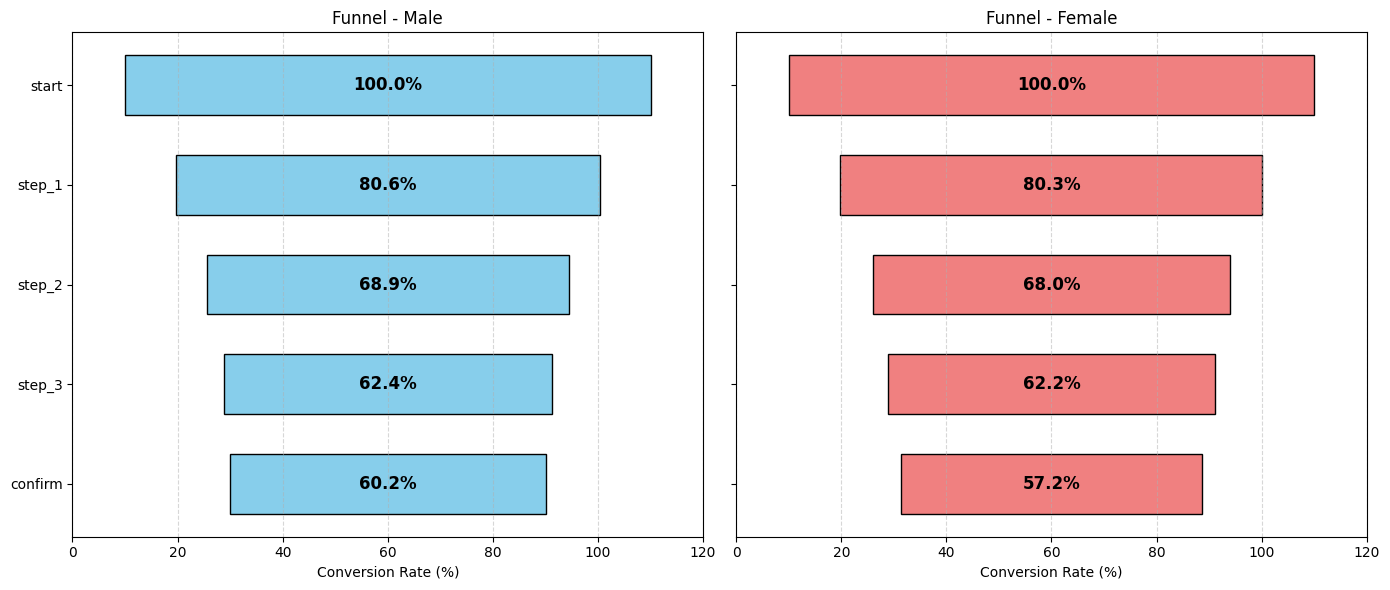

In [36]:
# Step order
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]
x_center = 60  # Horizontal midpoint for centering bars

# Compute additional funnel metrics
def compute_step_conversion(df):
    df = df.set_index("step").reindex(step_order, fill_value=0)
    df["step_conversion"] = df["step_count"] / df["step_count"].shift(1) * 100
    df["conversion_rate"] = df["conversion_rate"] * 100  # convert to percentage
    return df[::-1]  # reverse order so start is at top

# Prepare data for each gender
df_m = results_df[results_df['gender'] == 'M'].copy()
df_f = results_df[results_df['gender'] == 'F'].copy()
df_m = compute_step_conversion(df_m)
df_f = compute_step_conversion(df_f)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, df_gender, title, color in zip(
    axes, [df_m, df_f], ["Male", "Female"], ["skyblue", "lightcoral"]
):
    steps = df_gender.index.tolist()
    conv_start = df_gender["conversion_rate"].tolist()
    y = np.arange(len(steps))
    left_offsets = [x_center - (val / 2) for val in conv_start]

    for i in range(len(steps)):
        ax.barh(y[i], conv_start[i], height=0.6,
                left=left_offsets[i], color=color, edgecolor='black')
        ax.text(x_center, y[i], f"{conv_start[i]:.1f}%",
                ha='center', va='center', fontsize=12, fontweight='bold', color='black')

    ax.set_yticks(y)
    ax.set_yticklabels(steps)
    ax.set_xlim(0, 120)
    ax.set_xlabel("Conversion Rate (%)")
    ax.set_title(f"Funnel - {title}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)



plt.tight_layout()
plt.show()


3. OTHER HYPOTHESIS: TIME DIFFERENCES IN EACH STEP BY TEST/CONTROL GROUPS

In [20]:
# Sort and compute durations
df = df.sort_values(by=['visit_id', 'date_time'])
df['next_time'] = df.groupby('visit_id')['date_time'].shift(-1)
df['duration'] = (df['next_time'] - df['date_time']).dt.total_seconds()
df = df.dropna(subset=['duration'])

# Merge variation info
df = df.merge(variation_df, on='client_id', how='left')

# Define step order
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df['process_step'] = pd.Categorical(df['process_step'], categories=step_order, ordered=True)

# Perform t-tests per step
results = []
for step in step_order:
    test_group = df[(df['process_step'] == step) & (df['Variation'] == 'Test')]['duration']
    control_group = df[(df['process_step'] == step) & (df['Variation'] == 'Control')]['duration']
    
    if len(test_group) < 2 or len(control_group) < 2:
        continue

    t_stat, p_val = ttest_ind(test_group, control_group, equal_var=False)
    results.append({
        'step': step,
        'test_mean_sec': test_group.mean(),
        'control_mean_sec': control_group.mean(),
        'p_value': p_val,
        'significant': p_val < 0.05
    })

# Format results
results_df = pd.DataFrame(results)
results_df['test_mean_min'] = (results_df['test_mean_sec'] / 60).round(2)
results_df['control_mean_min'] = (results_df['control_mean_sec'] / 60).round(2)
results_df = results_df[['step', 'test_mean_min', 'control_mean_min', 'p_value', 'significant']]

print(results_df)

      step  test_mean_min  control_mean_min       p_value  significant
0    start           1.01              1.05  1.704363e-01        False
1   step_1           1.01              0.84  1.442270e-17         True
2   step_2           1.48              1.53  3.143453e-02         True
3   step_3           2.15              2.26  1.265607e-03         True
4  confirm           4.13              2.87  1.671734e-11         True
